# A/B тест

Анализируем влияние нового дизайна магазина (группа B) по сравнению со старым (группа A) на основе данных из Telegram-бота `AlbumShopBot`. Оцениваем 6 метрик:
1. Конверсия в покупку по типу устройств.
2. Средний чек (AOV).
3. Среднее количество товаров в заказе.
4. Среднее время на сайте перед покупкой.
5. Среднее количество просмотренных страниц перед покупкой.
6. Retention Rate.

Гипотезы для каждой метрики:
- H₀: различий между группами нет.
- H₁: различия есть (двусторонний тест).

In [71]:
import pandas as pd
import numpy as np
from statsmodels.stats.proportion import proportions_ztest
import matplotlib.pyplot as plt
import seaborn as sns

visits_a = pd.read_csv('./old_shop_visits.csv')
visits_b = pd.read_csv('./new_shop_visits.csv')
orders_a = pd.read_csv('./old_shop_orders.csv')
orders_b = pd.read_csv('./new_shop_orders.csv')

orders_a.dropna(inplace=True)
orders_b.dropna(inplace=True)

orders_a['group'] = 'A'
orders_b['group'] = 'B'
visits = pd.concat([visits_a, visits_b], ignore_index=True)
orders = pd.concat([orders_a, orders_b], ignore_index=True)

## 1. Конверсия в покупку по типу устройств
Конверсия = Уникальные покупатели / Уникальные посетители.

In [72]:
def calc_conversion(visits, orders, device_type):
    visits_dev = visits[visits['device'] == device_type]
    unique_visitors = visits_dev.groupby('group')['user_id'].nunique()
    orders_dev = orders.merge(visits_dev[['user_id', 'group']], on=['user_id', 'group'], how='inner')
    unique_buyers = orders_dev.groupby('group')['user_id'].nunique().reindex(['A', 'B'], fill_value=0)
    conv_rate = unique_buyers / unique_visitors
    stat, pval = proportions_ztest(unique_buyers, unique_visitors)
    return conv_rate, pval

conv_mobile, pval_mobile = calc_conversion(visits, orders, 'Mobile')
conv_desktop, pval_desktop = calc_conversion(visits, orders, 'Desktop')

print(f"Mobile: A = {conv_mobile['A']:.3f}, B = {conv_mobile['B']:.3f}, p-value = {pval_mobile:.3f}")
print(f"Desktop: A = {conv_desktop['A']:.3f}, B = {conv_desktop['B']:.3f}, p-value = {pval_desktop:.3f}")

Mobile: A = 0.077, B = 0.222, p-value = 0.278
Desktop: A = 0.324, B = 0.472, p-value = 0.171


## 2. Средний чек (AOV)
AOV = Общая выручка / Количество заказов.

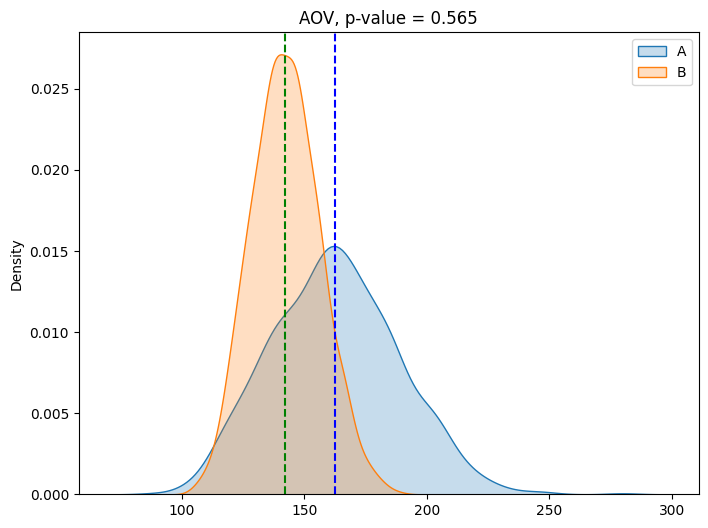

AOV: A = 162.42, B = 141.92, p-value = 0.565


In [73]:
def bootstrap_mean(data, col, group, n=1000):
    group_data = data[data['group'] == group][col]
    return [np.mean(np.random.choice(group_data, len(group_data), replace=True)) for _ in range(n)]

aov_a = orders[orders['group'] == 'A']['total_cost'].mean()
aov_b = orders[orders['group'] == 'B']['total_cost'].mean()
boot_aov_a = bootstrap_mean(orders, 'total_cost', 'A')
boot_aov_b = bootstrap_mean(orders, 'total_cost', 'B')
pval_aov = np.mean(np.abs(np.array(boot_aov_a) - np.array(boot_aov_b)) >= np.abs(aov_a - aov_b))

plt.figure(figsize=(8, 6))
sns.kdeplot(boot_aov_a, label='A', fill=True)
sns.kdeplot(boot_aov_b, label='B', fill=True)
plt.axvline(aov_a, color='blue', linestyle='--')
plt.axvline(aov_b, color='green', linestyle='--')
plt.legend()
plt.title(f'AOV, p-value = {pval_aov:.3f}')
plt.show()

print(f"AOV: A = {aov_a:.2f}, B = {aov_b:.2f}, p-value = {pval_aov:.3f}")

## 3. Среднее количество товаров в заказе
Среднее = Сумма товаров / Количество заказов.

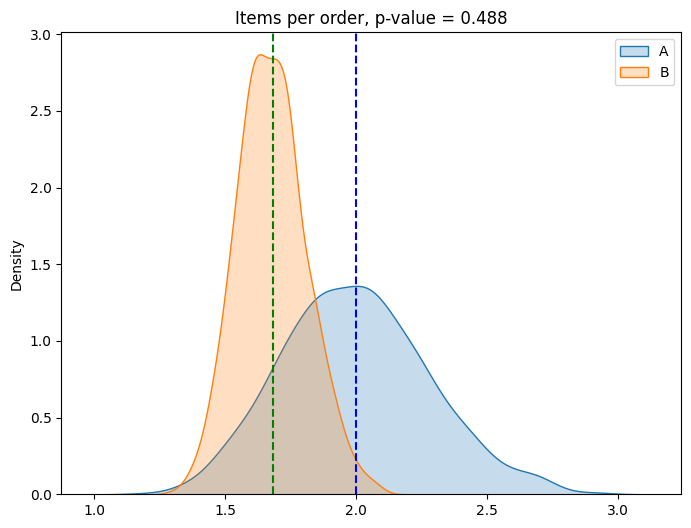

Items: A = 2.00, B = 1.68, p-value = 0.488


In [74]:
orders['quantities'] = orders['quantities'].apply(lambda x: sum(map(int, x.split(','))) if isinstance(x, str) else 0)
items_a = orders[orders['group'] == 'A']['quantities'].mean()
items_b = orders[orders['group'] == 'B']['quantities'].mean()
boot_items_a = bootstrap_mean(orders, 'quantities', 'A')
boot_items_b = bootstrap_mean(orders, 'quantities', 'B')
pval_items = np.mean(np.abs(np.array(boot_items_a) - np.array(boot_items_b)) >= np.abs(items_a - items_b))

plt.figure(figsize=(8, 6))
sns.kdeplot(boot_items_a, label='A', fill=True)
sns.kdeplot(boot_items_b, label='B', fill=True)
plt.axvline(items_a, color='blue', linestyle='--')
plt.axvline(items_b, color='green', linestyle='--')
plt.legend()
plt.title(f'Items per order, p-value = {pval_items:.3f}')
plt.show()

print(f"Items: A = {items_a:.2f}, B = {items_b:.2f}, p-value = {pval_items:.3f}")

## 4. Среднее время на сайте перед покупкой
Среднее время = Сумма времени в сессиях с покупками / Количество сессий.

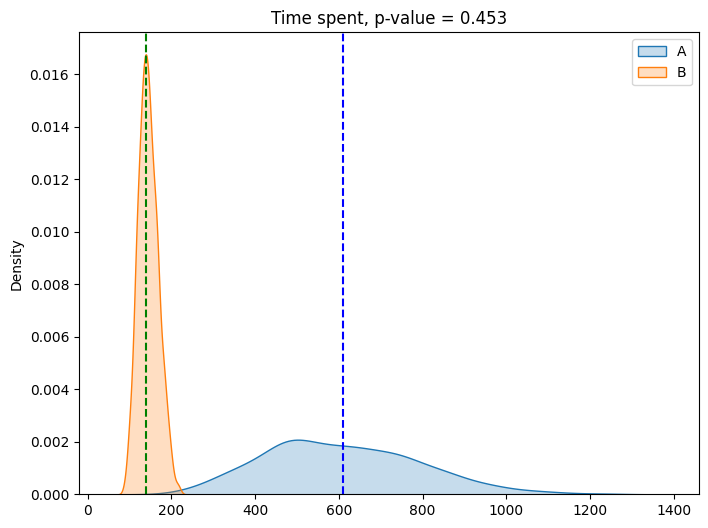

Time: A = 610.92, B = 138.17, p-value = 0.453


In [75]:
def bootstrap_mean(data, col, group, n=1000):
    group_data = data[data['group'] == group][col]
    return [np.mean(np.random.choice(group_data, len(group_data), replace=True)) for _ in range(n)]

sessions_a = visits[visits['user_id'].isin(orders[orders['group'] == 'A']['user_id'])]
sessions_b = visits[visits['user_id'].isin(orders[orders['group'] == 'B']['user_id'])]
time_a = sessions_a['time_spent'].mean()
time_b = sessions_b['time_spent'].mean()
boot_time_a = bootstrap_mean(sessions_a, 'time_spent', 'A')
boot_time_b = bootstrap_mean(sessions_b, 'time_spent', 'B')
pval_time = np.mean(np.abs(np.array(boot_time_a) - np.array(boot_time_b)) >= np.abs(time_a - time_b))

plt.figure(figsize=(8, 6))
sns.kdeplot(boot_time_a, label='A', fill=True)
sns.kdeplot(boot_time_b, label='B', fill=True)
plt.axvline(time_a, color='blue', linestyle='--')
plt.axvline(time_b, color='green', linestyle='--')
plt.legend()
plt.title(f'Time spent, p-value = {pval_time:.3f}')
plt.show()

print(f"Time: A = {time_a:.2f}, B = {time_b:.2f}, p-value = {pval_time:.3f}")

## 5. Среднее количество просмотренных страниц
Среднее = Сумма просмотров страниц / Количество сессий с покупками.

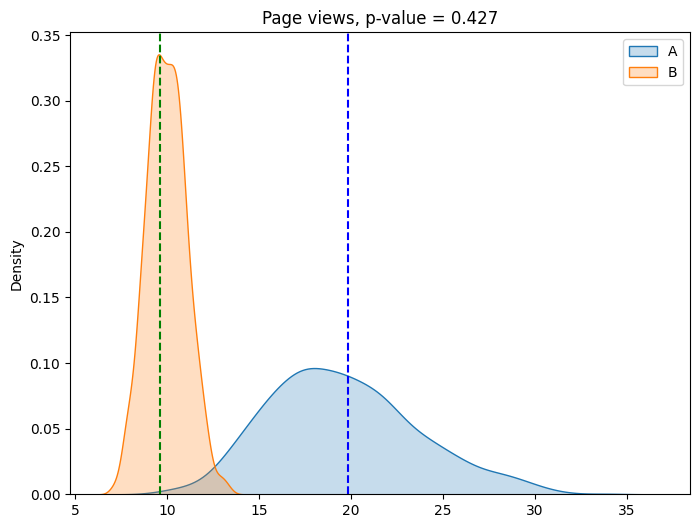

Pages: A = 19.83, B = 9.63, p-value = 0.427


In [76]:
pages_a = sessions_a['page_views'].mean()
pages_b = sessions_b['page_views'].mean()
boot_pages_a = bootstrap_mean(sessions_a, 'page_views', 'A')
boot_pages_b = bootstrap_mean(sessions_b, 'page_views', 'B')
pval_pages = np.mean(np.abs(np.array(boot_pages_a) - np.array(boot_pages_b)) >= np.abs(pages_a - pages_b))

plt.figure(figsize=(8, 6))
sns.kdeplot(boot_pages_a, label='A', fill=True)
sns.kdeplot(boot_pages_b, label='B', fill=True)
plt.axvline(pages_a, color='blue', linestyle='--')
plt.axvline(pages_b, color='green', linestyle='--')
plt.legend()
plt.title(f'Page views, p-value = {pval_pages:.3f}')
plt.show()

print(f"Pages: A = {pages_a:.2f}, B = {pages_b:.2f}, p-value = {pval_pages:.3f}")

## 6. Retention Rate
Retention = Пользователи с покупкой не в первый визит / Все покупатели.

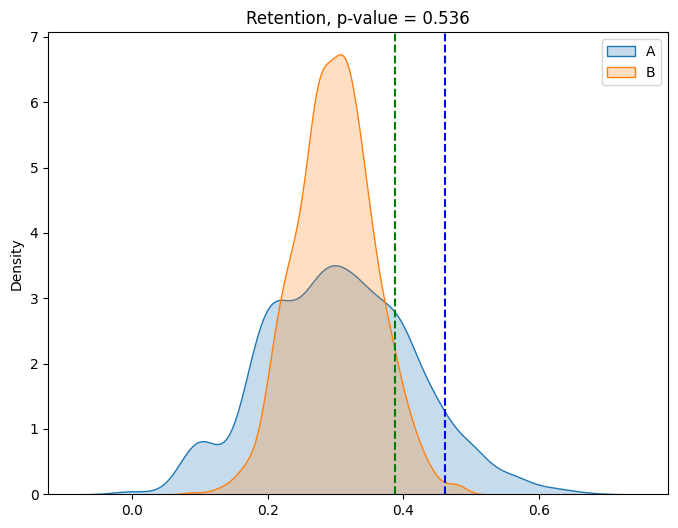

Retention: A = 0.462, B = 0.387, p-value = 0.536


In [77]:
def calc_retention(visits, orders):
    visits_per_user = visits.groupby('user_id')['visit_date'].nunique()
    buyers = orders['user_id'].unique()
    repeat_buyers = visits_per_user[visits_per_user > 1].index.intersection(buyers)
    return len(repeat_buyers) / len(buyers)

retention_a = calc_retention(visits[visits['group'] == 'A'], orders[orders['group'] == 'A'])
retention_b = calc_retention(visits[visits['group'] == 'B'], orders[orders['group'] == 'B'])
boot_ret_a = [calc_retention(visits[visits['group'] == 'A'].sample(frac=1, replace=True), 
                             orders[orders['group'] == 'A'].sample(frac=1, replace=True)) for _ in range(1000)]
boot_ret_b = [calc_retention(visits[visits['group'] == 'B'].sample(frac=1, replace=True), 
                             orders[orders['group'] == 'B'].sample(frac=1, replace=True)) for _ in range(1000)]
pval_ret = np.mean(np.abs(np.array(boot_ret_a) - np.array(boot_ret_b)) >= np.abs(retention_a - retention_b))

plt.figure(figsize=(8, 6))
sns.kdeplot(boot_ret_a, label='A', fill=True)
sns.kdeplot(boot_ret_b, label='B', fill=True)
plt.axvline(retention_a, color='blue', linestyle='--')
plt.axvline(retention_b, color='green', linestyle='--')
plt.legend()
plt.title(f'Retention, p-value = {pval_ret:.3f}')
plt.show()

print(f"Retention: A = {retention_a:.3f}, B = {retention_b:.3f}, p-value = {pval_ret:.3f}")

## Итог
Почти во всех  тестах группа B показала наивысшие результаты.